<center>
    <h1> Proyecto #1 - Multigrid </h1>
    <h4 style="margin:10px;"> IPM-407 - Modelación Computacional con Algoritmos Rápidos </h4>
    <h3> Hernán Vargas -- 201073009-3 </h3>
    <h4 style="margin:5px;"> hernan.vargas@alumnos.usm.cl </h4>
</center>

*(Se recomienda la visualización de este documento en Jupyter Notebook 5.0, Kernel: Python 3.5.2)*

La ecuación diferencial

$$ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = -2\big((1-6x^2)y^2(1-y^2)+(1-6y^2)x^2(1-x^2)\big) $$

con $u = 0$ en $x=0, x=1, y=0, y=1$ y $0<x, y<1$ tiene como solución analítica:

$$ u(x,y) = (x^2-x^4)(y^4 - y^2) $$

Resuelva la ecuación diferencial númericamente con una discretización de segundo orden, usando:
1. Gauss-Seidel.
2. V-cycle, con $v_1=2$ y $v_2=2$ iteraciones subiendo y bajando en las mallas.
3. Multigrid, con $v_0=1$ V-cycle por malla.

Considere lo siguiente:
- Malla fina con 129 nodos por dimensión ($\Delta x = \frac{L}{N-1}$).
- Interpolación lineal y *full weightening* como operadores entre mallas.
- Tolerancia de $10^{-8}$ del residual

Además debe:
- Indicar el número de iteraciones, V-cycles, multigrids necesarios para llegar a la solución en cada caso.
- Indicar el tiempo de solución en cada caso ¿Se cumple la predicción téorica que vimos en clases? (recuerde que cualificamos la cantidad de operaciones por unidad de ciclos de Gauss-Seidel)
- Realizar simulaciones con malla fina de 65, 129, 257 nodos por dimensión usando V-cycles y Multigrid, y graficar el tiempo de solución versus el tamaño de malla fina (gráfico *log-log*) ¿Se cumple la complejidad algoritmica que derivamos en clase?
- Estudie el efecto de varias $v_0, v_1$ y $v_2$ ¿Puede proponer una combinación ideal?
- Estudie el efecto de cambiar *full weightening* por *injection*.

## Introducción
Comencemos importando las biblotecas necesarias para el desarrollo de este proyecto, además se definen algunas de las variables que se utilizarán a lo largo del desarrollo.

In [1]:
import numpy as np;
import scipy as sp;
from scipy import linalg;
from scipy import sparse;
from scipy.sparse import linalg;
import matplotlib;
import matplotlib.pyplot as plt;
import time;

In [2]:
sol    = lambda x,y: (x**2 - x**4)*(y**4 - y**2); # Solución analítica.
nodes  = [65, 129, 257];                # Número de nodos de los experimentos.
TOL    = 1e-8;                          # Tolerancia del residual.
MAXIT  = 3000;                          # Iteraciones máximas.
L      = 1;                             # Largo de la malla, en este caso (1 - 0) para x e y
get_dx = lambda N: (L / (N-1));         # Distancia entre los puntos

La ecuación con la que trabajamos puede ser representada como:
$$ \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = g(x,y) $$
con:
$$ g(x,y) = -2\big((1-6x^2)y^2(1-y^2)+(1-6y^2)x^2(1-x^2)\big) $$

In [3]:
g   = lambda x,y: -2*(((1-(6*x**2))*(y**2)*(1-y**2)) + ((1-(6*y**2))*(x**2)*(1-x**2)));

Sea la interpolación de segundo orden para las derivadas de $u$:

$$ \frac{\partial^2 u}{\partial x^2} = \frac{u_{i-1,j}-2u_{i,j}+u_{i+1,j}}{\Delta x^2} $$
$$ \frac{\partial^2 u}{\partial y^2} = \frac{u_{i,j-1}-2u_{i,j}+u_{i,j+1}}{\Delta y^2} $$

luego:

$$ \frac{u_{i-1,j}-2u_{i,j}+u_{i+1,j}}{\Delta x^2} + 
   \frac{u_{i,j-1}-2u_{i,j}+u_{i,j+1}}{\Delta y^2} = g(x_i,y_j)$$

Para nuestro caso sabemos $\Delta x =\Delta y = \Delta$, luego:

$$ -4u_{i,j} + u_{i-1,j} + u_{i+1,j} + u_{i,j-1}+u_{i,j+1} = \Delta^2 g(x_i,y_j)$$

Podemos crear el sistema de ecuaciones $A\vec{x} = \vec{b}$ con:

$$
A = \left( \begin{array}{ccc}
  D & I &   &   & \\
  I & D & I &   & \\
    & I & \ddots & \ddots & \\
    &   & \ddots & \ddots & I \\
    & &   & I & D \\
\end{array} \right)_{(n-2) \times (n-2)}
$$

$$ \vec{x} = [u_{1,1},u_{2,1},\dots, u_{n,1}, u_{1,2}, \dots, u_{n-1,n-1}]^{T} $$
$$ \vec{b} = [\Delta ^2 g(x_1,y_1), \Delta ^2 g(x_2,y_1), \dots,
              \Delta ^2 g(x_{n-1},y_{n-1})]^{T} $$

Donde: (n-2)x(n-2) TODO
$$
D = \left( \begin{array}{ccc}
  -4 &  1 & & & \\
   1 & -4 & 1 & & \\
     & \ddots & \ddots &\ddots  & \\
     & & \ddots &\ddots &  1 \\
     & & & 1 & -4 
\end{array} \right)_{(n-2)\times(n-2)}\,\,\,
I = \left( \begin{array}{ccc}
  1 &  & \\
   & \ddots &  \\
   &  & 1
\end{array} \right)_{(n-2)\times(n-2)}
$$

En base a ello se definen funciones para obtener tanto la matriz $A$ como el vector $b$ para una malla arbitraria.

In [4]:
def get_A(n, sparse = False):
    """ Crea la matriz laplaciana para un problema con bordes 0.
    Como los bordes son 0 no se guardan.
    Argumentos:
        n      -- Número de puntos por dimensión.
        sparse -- (Opcional) Si es verdadero se crea una matriz sparse.
    Retorna: Matriz laplaciana de (n-2)^2 x (n-2)*2
    """
    if n < 3: return None;
    n = n-2
    if not sparse:
        D = np.diag(-4* np.ones(n)) + np.diag(np.ones(n-1), 1) + np.diag(np.ones(n-1), -1);
        return sp.linalg.block_diag(*[D]*n) + np.diag(np.ones(n*(n-1)), n) + np.diag(np.ones(n*(n-1)), -n);
    else:
        N = n**2;
        main_diag = np.ones(N)*-4.0;
        side_diag = np.ones(N-1);
        up_down_diag = np.ones(N-3);
        side_diag[np.arange(1,N)%n==0] = 0;
        return sp.sparse.diags([main_diag,side_diag,side_diag,up_down_diag,up_down_diag], [0, -1, 1,n,-n], format="csc");

In [96]:
def get_b(n):
    """ Crea el vector b, con el lado derecho de la ecuación g(x,y)*dx^2.
    Como las condiciones de borde son 0 no las guarda.
    Argumentos:
        n -- Número de puntos por dimensión.
    Retorna: Vector de (n-2)**2 elementos.
    """
    dx = get_dx(n);
    b  = np.zeros((n-2)**2);
    for j in range(1,n-1):
        for i in range(1,n-1):
            b[(j-1)*(n-2) + (i-1)] = (dx**2) * g(dx*i, dx*j);
    return b;

## Gauss-Seidel
Podemos resolver el sistema $A\vec{x} = \vec{b}$ con el metodo iterativo de Gauss-Seidel. 

Sea $A = (D + L + U)$ tenemos:

\begin{align}
 A\vec{x} &= \vec{b} \\
 (D + L + U)x &= b \\
 (D + L)x &= b - Ux \\
 x^{k+1} &= (D + L)^{-1}(b - Ux^k)
\end{align}

Donde $x^{k}$ será la aproximación de la solución en la k-ésima iteración.

Podemos calcular el residual como $r = Ax - Ax^{k+1} = b - Ax^{k+1}$, luego el criterio de término del algoritmo será cuando
la norma 2 del residual sea menor a cierta tolerancia.

In [6]:
def gs(A, b, x = None, maxit = MAXIT, info = {}):
    """ Resuelve la ecuación vectorial Ax = b con el método de Gauss-Seidel.
    Funciona para matrices sparse.
    Argumentos:
        A      -- Matriz A.
        b      -- Vector b.
        x      -- (Opcional) Aproximación inicial, por defecto 0.
        maxit  -- (Opcional) Número máximo de iteraciones, por defecto MAXIT.
        info   -- (Opcional) Diccionario donde se guardará información de la ejecución.
    Retorna: Vector con las soluciones sistema."""
    if not isinstance(x, np.ndarray):
        x = np.zeros_like(b);
    sparse = sp.sparse.issparse(A);
    res  = 1.0;
    info["time"] = time.time();
    if sparse:
        L  = sp.sparse.tril(A);
        Li = sp.sparse.linalg.inv(L);
        U = A - L;
        for k in range(maxit):
            x = Li.dot(b - U.dot(x));
            res = np.linalg.norm(b - A.dot(x));
            if res < TOL: break;
    else:
        L  = np.tril(A);
        Li = np.linalg.inv(L);
        U = A - L;
        for k in range(maxit):
            x = np.dot(Li, b - np.dot(U, x))
            res = np.linalg.norm(b - np.dot(A, x));
            if res < TOL: break;
    info["loop"]  = k + 1;
    info["time"]  = (time.time() - info["time"])*1000.0;
    info["res"] = res;
    info["result"] = x;
    return x;

Para poder visualizar los resultados (y compararlos con la solución analítica) debemos transformar el vector solución $\vec{x}$ en una matriz, para ello se definen las siguientes útilidades:

In [7]:
def mk_sol(n):
    """Crea una matriz con la solución analítica.
    Argumetos:
        n -- Número de puntos de la malla por dimensión.
    Retorna: Malla con los resultados analíticos."""
    dx = get_dx(n);
    s = np.zeros((n,n));
    for i in range(n):
        for j in range(n):
            s[i,j] = sol(dx*i, dx*j);
    return s;

In [8]:
def mk_appr(x):
    """Crea una matriz con la solución aproximada.
    Agrega las condiciones de borde que antes fueron descartadas.
    Argumetos:
        x -- vector con la solución.
    Retorna: Malla con los resultados aproximados."""
    n = int(np.sqrt(x.shape[0]) + 2);
    s = np.zeros((n,n));
    for j in range(1, n-1):
        for i in range(1, n-1):
            s[j, i] = x[(j-1)*(n-2) + (i-1)];
    return s;

El código implementado para la resolución por Gauss-Seidel, tiene dos grandes debilidades:
1. La útilización de matrices muy grandes aumenta el uso de memoria. La matriz $A$ tiene tantos elementos como variables por dimensión, aún quitando las condiciones de borde tenemos una matriz de $(n-2)^2\times(n-2)^2$ con $n$ el número de nodos por dimensión en la malla.
2. La utilización de la inversa de la matriz $A$ en el algoritmo aumenta considerablemente los tiempos de ejecución totales ya que calcular inversas es muy costoso.

Para atacar el primer punto se da la opción de utilizar matrices *sparse* las cuales solo guardan los elementos no nulos, ideal para almacenar la matriz $A$ ya que esta solo tiene 5 diagonales. Por otro lado, para evitar el punto dos debemos generar un nuevo algoritmo que evite el calculo de la inversa.

Podemos quitar la inversa del algoritmo haciendo lo siguiente:
\begin{align}
 (D + L + U)x &= b \\
 (D + L)x &= b - Ux \\
 (D + L)x^{k+1} &= b - Ux^k \\
 Dx^{k+1} &= b - Ux^k - Lx^{k+1}\\
\end{align}

Luego calculamos este resultado para cada elemento del vector $x$ iterando con la siguiente formula:

$$
x^{k+1}_i  = \frac{1}{D_{ii}} \left(b_i - \sum_{j>i}a_{ij}x^{k}_j - \sum_{j<i}a_{ij}x^{k+1}_j \right),\quad i,j=1,2,\ldots,n
$$

In [9]:
def gs2(A, b, x = None, maxit = MAXIT, info = {}):
    """ Resuelve la ecuación vectorial Ax = b con el método de Gauss-Seidel.
    Calcula el resultado del vector x iterativamente.
    Argumentos:
        A      -- Matriz A.
        b      -- Vector b.
        x      -- (Opcional) Aproximación inicial, por defecto 0.
        maxit  -- (Opcional) Número máximo de iteraciones, por defecto MAXIT.
        info   -- (Opcional) Diccionario donde se guardará información de la ejecución.
    Retorna: Vector con las soluciones sistema."""
    if not isinstance(x, np.ndarray):
        x  = np.zeros_like(b);
    x2  = np.zeros_like(x);
    res = 1.0;
    info["time"] = time.time();
    
    for k in range(maxit):
        for i in range(A.shape[0]):
            s1 = np.dot(A[i, :i], x2[:i]);         #U
            s2 = np.dot(A[i, i + 1:], x[i + 1:]);  #L
            x2[i] = (b[i] - s1 - s2) / A[i, i];    #D
            
        res = np.linalg.norm(b - np.dot(A, x2));
        if res < TOL: break;

        x = x2;
    info["loop"] = k + 1;
    info["time"] = (time.time() - info["time"])*1000.0;
    info["res"]  = res;
    info["result"] = x;
    return x

A pesar de no calcular la inversa en esta implementación, se hacen demasiadas operaciones entre matrices.
Si queremos mejorar los resultados para la resolución de este problema tendremos que generar un 
algoritmo especifico que utilice todas las caracteristicas que conocemos de la ecuación.

En primer lugar, para solucionar el problema de uso de memoria no se resolverá el problema $Ax = b$,
en vez de ello, calcularemos la solución directamente en la malla.

Por Gauss-Seidel sabemos que cada punto se puede calcular como:

\begin{align}
 (D + L)x^{k+1} &= b - Ux^k \\
 Dx^{k+1} &= b - Ux^k - Lx^{k+1}\\
 -4x^{k+1} &= \Delta^2 g(x_i,y_j) - (x^{k}_{i+1,j} + x^{k}_{i,j+1}) - (x^{k+1}_{i−1,j} + x^{k+1}_{i,j−1})\\
  x^{k+1} &=  \frac{x^{k}_{i+1,j} + x^{k}_{i,j+1} + x^{k+1}_{i−1,j} + x^{k+1}_{i,j−1} - \Delta^2 g(x_i,y_j)}{4}
\end{align}

Así, se genera un algoritmo iterativo que solo requiere el número de puntos de la malla.

Como en este algoritmo no almacenamos las matrices utilizaremos como criterio de termino la norma 2 de la diferencia de dos iteraciones consecutivas.

In [107]:
def my_gs(n, x = None, b= None, maxit = MAXIT, info = {}):
    """ Resuelve el problema especifico de este trabajo con el método de Gauss-Seidel.
    Calcula la malla final iterativamente.
    Este algoritmo solo resuelve problemas de la ecuación discreta de Poisson en dos dimensiones.
    Argumentos:
        n      -- Número de nodos de la malla por dimensión.
        x      -- (Opcional) Malla inicial, por defecto 0.
        b      -- (Opcional) Vector b del problema.
        maxit  -- (Opcional) Número máximo de iteraciones, por defecto MAXIT.
        info   -- (Opcional) Diccionario donde se guardará información de la ejecución.
    Retorna: Matriz con la malla solución."""
    if not isinstance(x, np.ndarray): x = np.zeros(shape=(n,n));
    if not isinstance(b, np.ndarray): b = get_b(n);
    info["time"] = time.time();
    for k in range(maxit):
        diff = 0.0;
        x2prev = np.sum(x**2);
        for i in range(1,n-1):
            for j in range(1,n-1):
                prev = x[i][j];
                x[i][j] = .25 * (x[i+1][j] + x[i-1][j] + x[i][j+1] + x[i][j-1] - b[(j-1)*(n-2) + (i-1)]);
                diff += (x[i][j] - prev)**2;
        diff = np.sqrt(diff/(x2prev + 1e-15));
        if diff < TOL: break;
    info["loop"]  = k + 1;
    info["time"]  = (time.time() - info["time"])*1000.0;
    info["res"] = diff;
    info["result"] = x;
    return x;

Con todos los Gauss-Seidel implementados, comparamos los resultados de la ejecución para decidir cual utilizaremos para los siguientes ejercicios.

In [12]:
infoGS   = {};
lowtest  = [17,33, 49, 65]; # Pruebas generales.
hightest = [81, 97, 113];   # Pruebas para los que consumen menos memoria.

In [13]:
#Ejecución de las pruebas
for n in lowtest:
    infoGS[n] = {"gs": {}, "gs2": {}, "gss": {}, "my_gs": {}};
    A, As, b = get_A(n), get_A(n, sparse=True), get_b(n);
    gs(A,b, info=infoGS[n]["gs"]);
    gs2(A,b, info=infoGS[n]["gs2"]);
    gs(As,b, info=infoGS[n]["gss"]);
    my_gs(n, info=infoGS[n]["my_gs"]);

/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:102: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:171: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


In [14]:
for n in hightest:
    infoGS[n] = {"gss": {}, "my_gs": {}};
    As, b = get_A(n, sparse=True), get_b(n);
    gs(As,b, info=infoGS[n]["gss"]);
    my_gs(n, info=infoGS[n]["my_gs"]);

/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:102: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:171: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


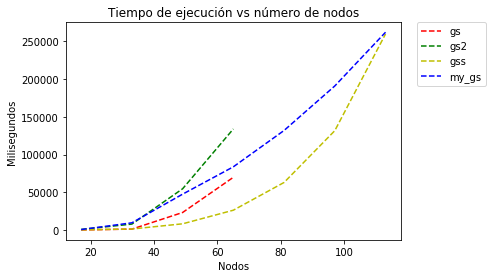

In [27]:
times = {};
for method in ["gs", "gs2", "gss", "my_gs"]:
    times[method] = [infoGS[n][method]["time"] for n in lowtest];
for method in ["gss", "my_gs"]:
    times[method] += [infoGS[n][method]["time"] for n in hightest];
    
plt.plot(lowtest, times["gs"], 'r--', label="gs");
plt.plot(lowtest, times["gs2"], 'g--', label="gs2");
plt.plot(lowtest+hightest, times["gss"], 'y--', label="gss");
plt.plot(lowtest+hightest, times["my_gs"], 'b--', label="my_gs");
plt.xlabel('Nodos')
plt.ylabel('Milisegundos')
plt.title('Tiempo de ejecución vs número de nodos')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show();

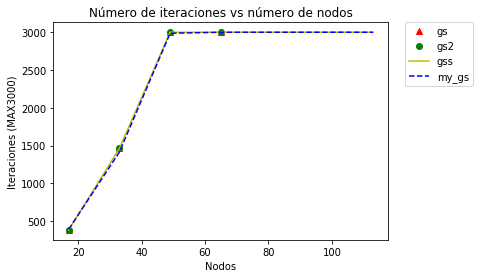

In [25]:
iters = {};
for method in ["gs", "gs2", "gss", "my_gs"]:
    iters[method] = [infoGS[n][method]["loop"] for n in lowtest];
for method in ["gss", "my_gs"]:
    iters[method] += [infoGS[n][method]["loop"] for n in hightest];
    
plt.plot(lowtest, iters["gs"], 'r^', label="gs");
plt.plot(lowtest, iters["gs2"], 'go', label="gs2");
plt.plot(lowtest+hightest, iters["gss"], 'y', label="gss");
plt.plot(lowtest+hightest, iters["my_gs"], 'b--', label="my_gs");
plt.xlabel('Nodos')
plt.ylabel('Iteraciones (MAX'+ str(MAXIT) +')')
plt.title('Número de iteraciones vs número de nodos')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show();

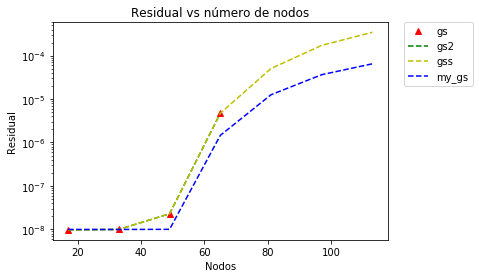

In [26]:
rest = {};
for method in ["gs", "gs2", "gss", "my_gs"]:
    rest[method] = [infoGS[n][method]["res"] for n in lowtest];
for method in ["gss", "my_gs"]:
    rest[method] += [infoGS[n][method]["res"] for n in hightest];
    
plt.plot(lowtest, rest["gs"], 'r^', label="gs");
plt.plot(lowtest, rest["gs2"], 'g--', label="gs2");
plt.plot(lowtest+hightest, rest["gss"], 'y--', label="gss");
plt.plot(lowtest+hightest, rest["my_gs"], 'b--', label="my_gs");
plt.xlabel('Nodos')
plt.ylabel('Residual')
plt.title('Residual vs número de nodos')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.yscale('log');
plt.show();

Como podemos ver, en terminos del número de iteraciones y del criterio de termino, los algoritmos se comportan de forma similar, obviamente esto se debe a que todos utilizan como base Gauss-Seidel.

En cuanto al consumo de memoria, solo el algoritmo que utiliza matrices *sparse* y aquel que no utiliza matrices pudieron ser ejecutados en la nuestra maquina de pruebas para un número relativamente alto de nodos.

Por último, en cuanto a los tiempos de ejecución, el Gauss-Seidel tradicional con matrices *sparse* parece ser el más rápido en las pruebas utilizadas, pero vemos como en el último experimento, con 112 nodos, la implementación de Gauss-Seidel especifica al problema logra igualar estos resultados.

Para comparar la calidad de la solución se definen funciones de comparación con la solución analitica.

In [31]:
def get_r(A, b, x):
    """ Calcula el residual de una malla solución x.
    Argumentos:
        A -- Matriz laplaciana del problema Ax = b;
        b -- Vector del lado derecho del problema.
        x -- malla solución a probar.
    Retorna: La norma dos del residual."""
    return np.sqrt(np.sum((b - A.dot(x[1:-1,1:-1].flatten()))**2));

In [32]:
def get_err(A, X):
    """ Calcula el error de una malla solucion.
    Argumentos:
        A -- Solución analítica para cierto número de nodos.
        X -- Aproximación obtenida para el mismo número de nodos.
    Retorna: La norma de la diferencia entre la solución analítica y la aproximada."""
    return np.linalg.norm(A-X);

A continuación se presenta una comparación de los resultados de todos los algoritmos para una malla de 65 nodos por dimensión.

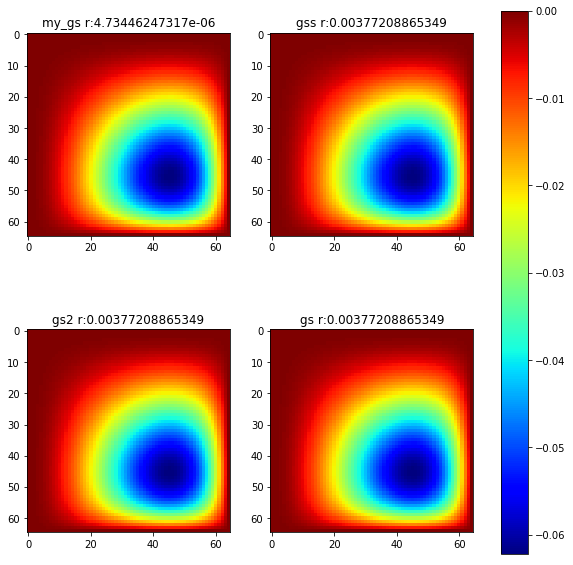

In [264]:
z = 65;
methods = [
    ("gs",  mk_appr(infoGS[z]["gs"]["result"])),
    ("gs2", mk_appr(infoGS[z]["gs2"]["result"])),
    ("gss", mk_appr(infoGS[z]["gss"]["result"])),
    ("my_gs", infoGS[z]["my_gs"]["result"])
];

A = get_A(z, sparse=True);
b = get_b(z);

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for ax in axes.flat:
    m, r = methods.pop();
    im = ax.imshow(r, cmap="jet");
    ax.set_title(m + " r:" + str(get_r(A, b, r)) );

fig.colorbar(im, ax=axes.ravel().tolist());
plt.show();

Como podemos notar, todos los algoritmos llegan a una solución cercana a la análitica, en especial *my_gs*, pero nuestro criterio para elegir cual utilizaremos en los próximos experimentos tambien debe considerar el tiempo de ejecución y el consumo de memoria. Los candidatos ideales parecen ser tanto Gauss-Seidel con matrices *sparse* y el algoritmo especifico para éste problema.

Es interesante evaluar su comportamiento para un número pequeño de iteraciones pues los métodos posteriores utilizarán esta caracteristica.

In [51]:
#Experimento para pocas iteraciones en los mejores métodos.
rango = range(1,11);  # Desde 1 a diez iteraciones
z = 65;               # Una malla de 65 nodos
A = get_A(z, sparse=True);
b = get_b(z);

infoIter = {};
for i in rango:
    infoIter[i] = {"gss": {}, "my_gs": {}};
    my_gs(z, maxit=i, info=infoIter[i]["my_gs"]);
    gs(A, b, maxit=i, info=infoIter[i]["gss"]);

/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:102: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:171: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


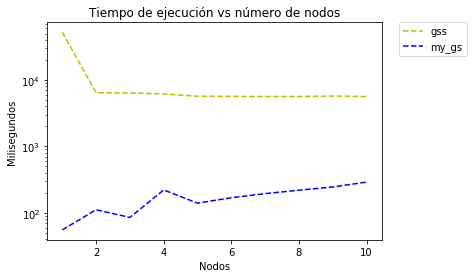

In [53]:
timesIter = {};
for method in ["gss", "my_gs"]:
    timesIter[method] = [infoIter[n][method]["time"] for n in rango];

plt.plot(rango, timesIter["gss"], 'y--', label="gss");
plt.plot(rango, timesIter["my_gs"], 'b--', label="my_gs");
plt.xlabel('Nodos')
plt.ylabel('Milisegundos')
plt.title('Tiempo de ejecución vs número de nodos')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.yscale('log');
plt.show();

Como notamos, el ganador en este experimento es claramente la implementación especifica de Gauss-Seidel para el problema particular de este informe. Los costos de inicialización de *my_gs* son practicamente despreciables y el tiempo de ejecución parece aumentar de manera constante al número de iteraciones. Por otro lado, el Gauss-Seidel Sparse tiene un costo de inicialización bastante alto y no hay muchos cambios por número de iteraciones. Debemos notar además que, gracias a las optimizaciones del computo, la inversa fue calculada sólo la primera vez, las demás ejecuciones pueden haberla obtenido del caché, situación poco probable en el ambito de los próximos algoritmos.

## V-cycle

La idea detras de *v-cycle* es la utilización de resultados del problema en mallas más gruesas como aproximación inicial para una malla mucho más fina. El algoritmo consiste en relajar sucesivamente una solución y transpasarla a mallas más gruesas (con menos nodos) por medio de operaciones de restricción. Cuando nos encontramos en la malla más gruesa relajamos (o solucionamos el problema) y subimos la solución hasta llegar a la malla más fina (con más nodos) por medio de interpolaciones y correcciones.

El algoritmo se define recursivamente como sigue:

$$ v^h \leftarrow V^h(v^h, f^h)$$
1. Relajar $v_1$ veces $A^hu^h=f^h$ con una aproximación inicial $v^h$.
1. Si $\Omega^{h}$ es la malla más gruesa ir al paso 4. Si no:
    - $ f^{2h} \leftarrow I_h^{2h} (f^h - A^hv^h)$,
    - $ v^{2h} \leftarrow 0 $, 
    - $ v^{2h} \leftarrow V^{2h}(v^{2h}, f^{2h}) $.
1. Corregir $v^{h} \leftarrow v^h + I_{2h}^{h} v^{2h}$.
1. Relajar $v_2$ veces $A^hu^h=f^h$ con una aproximación inicial $v^h$.

Para movernos entre las mallas se utilizan operaciones de restricción (*injection*, *half-weighting*, *full-weighting*) e interpolación (linear en dos dimensiones). Se definen a continuación:

In [54]:
def injection(A):
    """Restinge una matriz A de dimensiones NxN a las dimensiones [(N+1)/2]x[(N+1)/2]
    utilizando solo algunos puntos de la matriz original.
    Argumentos: 
        A -- Matriz a restringir.
    Retorna: Matriz restringida."""
    n = int((A.shape[0]+1)/2);
    R = np.empty((n,n), float);
    for i in range(n):
        for j in range(n):
            R[i][j] = A[2*i][2*j];
    return R;

In [55]:
def half_weighting(A):
    """Restinge una matriz A de dimensiones NxN a las dimensiones [(N+1)/2]x[(N+1)/2]
    ponderando en forma de cruz (arriba, abajo, izquierda, derecha y centro).
    Argumentos: 
        A -- Matriz a restringir.
    Retorna: Matriz restringida."""
    n = int((A.shape[0]+1)/2);
    R = np.empty((n,n), float);
    for i in range(n):
        for j in range(n):
            if i == 0 or j == 0 or i == n-1 or j == n-1:
                R[i][j] = A[2*i][2*j];
            else:
                R[i][j] = (A[2*i+1][2*j]+A[2*i-1][2*j]+A[2*i][2*j+1]+A[2*i][2*j-1]+4*A[2*i][2*j])/8
    return R;

In [56]:
def full_weighting(A):
    """Restinge una matriz A de dimensiones NxN a las dimensiones [(N+1)/2]x[(N+1)/2]
    ponderando en con los nueve nodos más cercanos al punto.
    Argumentos: 
        A -- Matriz a restringir.
    Retorna: Matriz restringida."""
    n = int((A.shape[0]+1)/2);
    R = np.empty((n,n), float);
    for i in range(n):
        for j in range(n):
            if i == 0 or j == 0 or i == n-1 or j == n-1:
                R[i][j] = A[2*i][2*j];
            else:
                R[i][j] = (
                    A[2*i+1][2*j+1]+A[2*i-1][2*j-1]+A[2*i-1][2*j+1]+A[2*i+1][2*j-1] 
                    + 2*(A[2*i+1][2*j]+A[2*i-1][2*j]+A[2*i][2*j+1]+A[2*i][2*j-1])
                    + 4*A[2*i][2*j])/16
    return R;

In [57]:
def linear_interpolation(A):
    """Hace una interpolación linear en dos dimensiones para transformar la malla A
    de NxN puntos a una malla R de 2N-1 puntos por dimensión.
    Argumentos: 
        A -- Matriz a interpolar.
    Retorna: Matriz interpolada."""
    m, n = A.shape
    R = np.empty((2*m-1, 2*n-1), float)
    R[0:  :2, 0:  :2] = A[0: ,0: ];
    R[1:-1:2, 0:  :2] = 0.5 * (A[0:-1,0:  ] + A[1: ,0: ]);
    R[0:  :2, 1:-1:2] = 0.5 * (A[0:  ,0:-1] + A[0: ,1: ]);
    R[1:-1:2, 1:-1:2] = 0.25* (A[0:-1,0:-1] + A[1: ,0:-1] + A[0:-1,1: ] + A[1: ,1: ]);
    return R

In [164]:
def vcycle(n, A = None, b = None, x = None, v1=2, v2=2, restrict=full_weighting):
    """Hace un vcycle para un problema de Poisson en 2 dimensiones.
    Argumentos:
        n        -- Número de nodos por dimensión.
        A        -- (Opcional) Matriz A del problema.
        b        -- (Opcional) Vector b del problema.
        x        -- (Opcional) Solución inicial. Por defecto 0.
        v1       -- (Opcional) Número de relajaciones hacia abajo. Por defecto 2.
        v2       -- (Opcional) Número de relajaciones hacia arriba. Por defecto 2.
        restrict -- (Opcional) Operador de restricción. Por defecto Full Weighting.
    Retorna: Aproximación de la solución despues de un vcycle.
    """
    dx = get_dx(n);
    if not isinstance(A, np.ndarray): A = get_A(n, sparse=True);
    if not isinstance(b, np.ndarray): b = get_b(n);
    if not isinstance(x, np.ndarray): x = np.zeros(shape=(n,n));

    #primera relajación
    x = my_gs(n, x=x, b=b, maxit=v1);
    if n > 7:
        r = b - A.dot(x[1:-1,1:-1].flatten());
        r = mk_appr(r);
        r2 = restrict(r)
        e2 = vcycle(r2.shape[0], b=r2[1:-1,1:-1].flatten(), v1=v1, v2=v2); #Ahora se resuelve la eq del error.
        e = linear_interpolation(e2); 
        x = x + e; #Se suma el error a la solución.
    #segunda relajación
    return my_gs(n, x=x, b=b, maxit=v2);

Podemos hacer un método iterativo con *vcycle* utilizando como aproximación inicial para cada ciclo el resultado del ciclo anterior:

In [249]:
def vcycle_iter(n, x = None, v1=2, v2=2, restrict=full_weighting, tol=TOL, maxit=MAXIT, info={}):
    """Ejecuta iterativamente vcycles hasta que se alcance el número máximo de iteraciones o 
    el residuo (a la solución analítica) sea menor que cierta tolerancia.
    Argumentos:
        n        -- Número de nodos por dimensión de la malla.
        x        -- (Opcional) Malla con la solución inicial, por defecto 0.
        v1       -- (Opcional) Número de relajaciones hacia abajo. Por defecto 2.
        v2       -- (Opcional) Número de relajaciones hacia arriba. Por defecto 2.
        restrict -- (Opcional) Operador de restricción. Por defecto Full Weighting.
        tol      -- (Opcional) Tolerancia del residual a alcanzar. Por defecto TOL.
        maxit    -- (Opcional) Número máximo de iteraciones. Por defecto MAXIT.
        info     -- (Opcional) Diccionario donde se guarda información de la ejecución.
    Retorna: Aproximación por una serie de vcycles que cumple algún criterio de término.
    """
    A = get_A(n, sparse=True);
    b = get_b(n);
    S = mk_sol(n);
    info["time"]   = time.time();
    r2 = 1;
    for i in range(maxit):
        x = vcycle(n, A, b, x, v1, v2, restrict);
        r = get_r(A,b,x);
        if r2 - r < 1e-15:
            print("El algoritmo se estancó!")
            #break
        r2 = r;
        if r < tol: break;
    info["time"] = (time.time() - info["time"])*1000.0;
    info["loop"] = i+1;
    info["res"]  = r;
    info["result"] = x;
    return x;

## Multigrid

*Multigrid* se basa en la misma idea de *vcycle*: encontrar soluciones a problemas más simples y utilizarlas para mejorar la convergencia del problema más complejo. En este caso el *multigrid* utilizado usa una serie de *vcycles* para ir relajando desde una malla fina hasta una gruesa.

El método restringe el problema hasta alcanzar la malla más gruesa , luego resuelve con *vcycle*, sube una malla, resuelve con *vcycle* de nuevo y así hasta alcanzar la malla más fina.

El método se define recursivamente como siguie:

$$ v^h \leftarrow FMG^h(f^h) $$
1. Si $\Omega^h$ es la malla más gruesa, hacer $v^h \leftarrow 0$ y ir al paso 3. Si no:
    - $f^{2h} \leftarrow I_{h}^{2h}(f^h)$
    - $v^{2h} \leftarrow FMG^{2h}(f^{2h})$
2. Corregir $v^h \leftarrow I^h_{2h}v^{2h}$
3. Hacer $v^h \leftarrow V^h(v^h, f^h)$ $v_0$ veces.

In [246]:
def mg(x = None, v0=1, v1=2, v2=2, restrict=full_weighting):
    """Calcula una solución aproximada al problema de este informe por medio
    del metodo multigrid.
    Argumentos:
        x        -- Malla solución inicial o número de puntos de la malla inicial.
        v0       -- (Opcional) Número de vcycles por malla. Por defecto 1;
        v1       -- (Opcional) Número de relajaciones hacia abajo del vcycle. Por defecto 2.
        v2       -- (Opcional) Número de relajaciones hacia arriba del vcycle. Por defecto 2.
        restrict -- (Opcional) Operador de restricción. Por defecto Full Weighting.
    Retorna: Aproximación a la solución obtenida por multigrid."""
    if isinstance(x, np.ndarray):
        n = x.shape[0];
    elif isinstance(x, int):
        n = x;
        x = np.zeros(shape=(n,n));
    else:
        raise ValueError("x must be an int or np.array");
        
    if n > 7: #Si no estamos en la malla más gruesa
        x2 = restrict(x);
        x2 = mg(x2, v0, v1, v2, restrict);
        x  = linear_interpolation(x2);
    
    #Para gastar menos memoria.
    if v0 > 1 : A, b = get_A(n), get_b(n);
    else:       A, b = None, None;
        
    for _ in range(v0):
        x = vcycle(n, A=A, b=b, x=x, v1=v1, v2=v2, restrict=restrict);
    return x;

In [247]:
def mg_iter(n, v0=1, v1=2, v2=2, restrict=full_weighting, info={}, tol=TOL, maxit=MAXIT):
    """Ejecuta multigrids iterativamente hasta que el residuo sea menor a cieto número,
    alcanzar cierto número de iteraciones, o estancarse.
    Argumentos:
        n        -- Número de puntos de la malla a calcular.
        v0       -- (Opcional) Número de vcycles por malla. Por defecto 1;
        v1       -- (Opcional) Número de relajaciones hacia abajo del vcycle. Por defecto 2.
        v2       -- (Opcional) Número de relajaciones hacia arriba del vcycle. Por defecto 2.
        restrict -- (Opcional) Operador de restricción. Por defecto Full Weighting.
        info     -- (Opcional) Diccionario donde se guarda información de la ejecución.
        tol      -- (Opcional) Tolerancia del residuo. Por defecto TOL.
        maxit    -- (Opcional) Número máximo de iteraciones. Por defecto MAXIT.
    Retorna: Aproximación a la solución obtenida por multigrid."""
    r2 = 1;
    A = get_A(n);
    b = get_b(n);
    S = mk_sol(n);
    x = np.zeros(shape=(n,n));
    info["time"]   = time.time();
    for i in range(maxit):
        x = mg(x, v0, v1, v2, restrict);
        r = get_r(A,b,x);
        if r2 - r < 1e-15:
            print("El algoritmo se estancó!")
            break
        r2 = r;
        if r < tol: break;
    info["time"]   = (time.time() - info["time"])*1000.0;
    info["loop"]   = i+1;
    info["res"]    = r;
    info["result"] = x;
    return x;

## Comparaciones

En esta sección realizaremos algunas pruebas para comparar los métodos implementados.

Comenzamos con el número de iteraciones necesarias para llegar a la solución esperada. Como la máquina en la que trabajamos no es muy potente la prueba se ejecutará con 17, 33, 49 y 65 nodos.

In [254]:
smallnodes = [17, 33, 49, 65];
info = {}

for n in smallnodes:
    info[n] = {"gs": {}, "vc": {}, "mg": {}};
    my_gs(n, info=info[n]["gs"], maxit=10000);
    vcycle_iter(n, info=info[n]["vc"], maxit=10000);
    mg_iter(n, info=info[n]["mg"], maxit=10000);

El algoritmo se estancó!
El algoritmo se estancó!
El algoritmo se estancó!
El algoritmo se estancó!


### Iteraciones vs Número de nodos

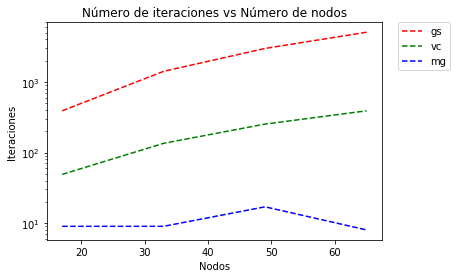

In [260]:
loops2 = {};
for method in ["gs", "vc", "mg"]:
    loops2[method] = [info[n][method]["loop"] for n in smallnodes];
    
plt.plot(smallnodes, loops2["gs"], 'r--', label="gs");
plt.plot(smallnodes, loops2["vc"], 'g--', label="vc");
plt.plot(smallnodes, loops2["mg"], 'b--', label="mg");
plt.xlabel('Nodos')
plt.ylabel('Iteraciones')
plt.title('Número de iteraciones vs Número de nodos')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.yscale('log');

plt.show();

En el gráfico del número de iteraciones podemos ver como cada algoritmo presenta resultados con ordenes de magnitud de diferencia. A pesar de que Gauss-Seidel solo pueda presentar más iteraciones, sería precipitado afirmar que és el algoritmo más lento, pues el número de operaciones y el tiempo que demora cada una de ellas es bastante menor que los otros dos.

Para poder hacer una buena comparación a continuación se presenta el gráfico de nodos vs tiempo.

### Tiempo vs Número de nodos

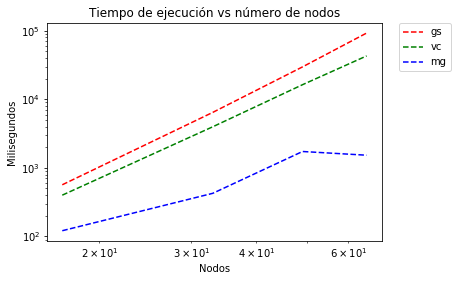

In [258]:
times2 = {};
for method in ["gs", "vc", "mg"]:
    times2[method] = [info[n][method]["time"] for n in smallnodes];
    
plt.plot(smallnodes, times2["gs"], 'r--', label="gs");
plt.plot(smallnodes, times2["vc"], 'g--', label="vc");
plt.plot(smallnodes, times2["mg"], 'b--', label="mg");
plt.xlabel('Nodos')
plt.ylabel('Milisegundos')
plt.title('Tiempo de ejecución vs número de nodos')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.yscale('log');
plt.xscale('log');

plt.show();

Las pendientes de los gráficos parecen ser lineales.

Como podemos notar, a pesar de que las operaciones de Gauss-Seidel sean más simples, siguie siendo más lento que *vcycle* y éste a su vez es más lento que *multigrid*, pero vemos un comportamiento extraño en este último. Para verificar que esta pasando veamos como se comporta el residual.

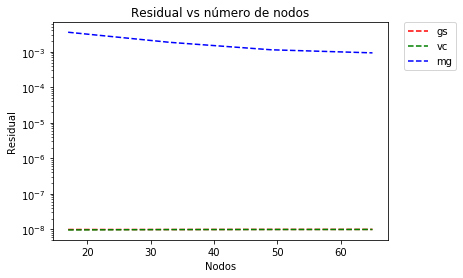

In [261]:
res2 = {};
for method in ["gs", "vc", "mg"]:
    res2[method] = [info[n][method]["res"] for n in smallnodes];
    
plt.plot(smallnodes, res2["gs"], 'r--', label="gs");
plt.plot(smallnodes, res2["vc"], 'g--', label="vc");
plt.plot(smallnodes, res2["mg"], 'b--', label="mg");
plt.xlabel('Nodos')
plt.ylabel('Residual')
plt.title('Residual vs número de nodos')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.yscale('log');

plt.show();

Como notamos, multigrid no está funcionando correctamente pues termina antes de alcanzar la tolerancia esperada.
En la misma ejecución se presentó el mensaje "El algoritmo se estancó" que ocurre cuando el residual entre una iteración
y la siguiente cambia muy poco. Iteraciones seguidas de multigrid no logran mejorar las soluciones.

El efecto de este error se puede apreciar en la siguiente comparación:

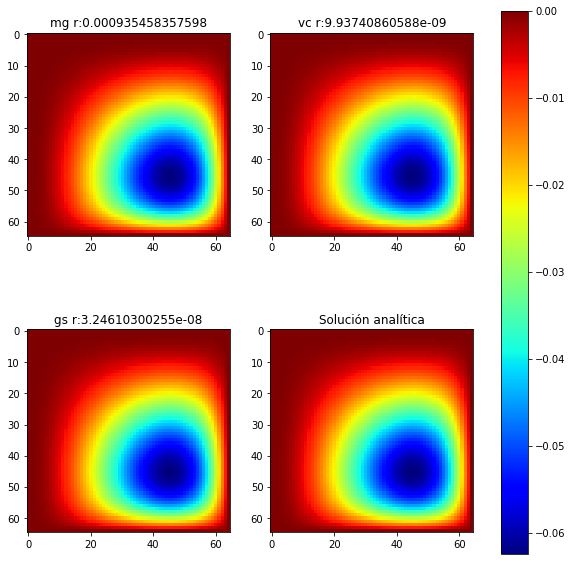

In [266]:
z = 65;
methods = [
    ("a",  mk_sol(z)),
    ("gs", info[z]["gs"]["result"]),
    ("vc", info[z]["vc"]["result"]),
    ("mg", info[z]["mg"]["result"])
];

A = get_A(z, sparse=True);
b = get_b(z);

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for ax in axes.flat:
    m, r = methods.pop();
    im = ax.imshow(r, cmap="jet");
    if not m == 'a':
        ax.set_title(m + " r:" + str(get_r(A, b, r)) );
    else:
        ax.set_title("Solución analítica");
        

fig.colorbar(im, ax=axes.ravel().tolist());
plt.show();

### Efecto de los cambios en v0 v1 y v2

Primero verifiquemos el efecto de $v1$ y $v2$ en *vcycle* para una malla de 33 nodos.

In [306]:
vresult = {};
vtime = {};
vloop = {};
ntest = 33;
v1s = [2,4,8,16];
v2s = [2,4,8,16];
for i in v1s:
    vresult[i] = {};
    vtime[i] = {};
    vloop[i] = {};

In [312]:
tmp = {};
for i in v1s:
    for j in v2s:
        vresult[i][j] = vcycle_iter(ntest,v1=i, v2=j, info=tmp);
        vtime[i][j] = tmp["time"];
        vloop[i][j] = tmp["loop"];

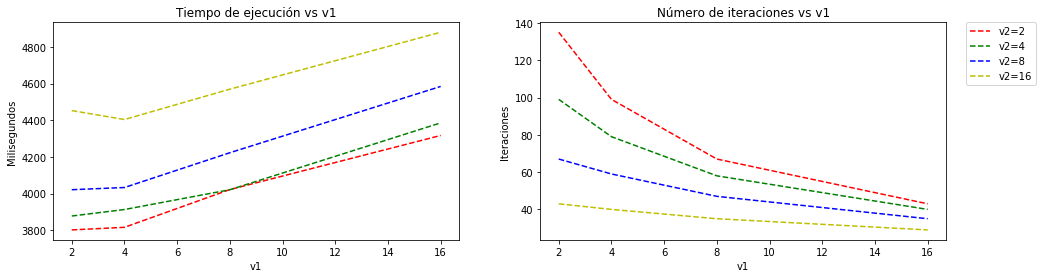

In [322]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4));

ax1.plot(v1s, [vtime[x][2] for x in v1s], 'r--', label="v2=2");
ax1.plot(v1s, [vtime[x][4] for x in v1s], 'g--', label="v2=4");
ax1.plot(v1s, [vtime[x][8] for x in v1s], 'b--', label="v2=8");
ax1.plot(v1s, [vtime[x][16] for x in v1s], 'y--', label="v2=16");
ax1.set_xlabel('v1')
ax1.set_ylabel('Milisegundos')
ax1.set_title('Tiempo de ejecución vs v1')

ax2.plot(v1s, [vloop[x][2] for x in v1s], 'r--', label="v2=2");
ax2.plot(v1s, [vloop[x][4] for x in v1s], 'g--', label="v2=4");
ax2.plot(v1s, [vloop[x][8] for x in v1s], 'b--', label="v2=8");
ax2.plot(v1s, [vloop[x][16] for x in v1s], 'y--', label="v2=16");
ax2.set_xlabel('v1')
ax2.set_ylabel('Iteraciones')
ax2.set_title('Número de iteraciones vs v1')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show();

Al parecer, mientras mayor sea tanto $v1$ como $v2$ la solución se encuentra en menos iteraciones pero el tiempo de ejecución aumenta.

Podemos notar como el tiempo de ejecución parece incrementar linealmente despues de $v1=4$ mientras que número de iteraciones no disminuye a la misma frecuencia.

La convinación ideal deben ser valores de $v1$ y $v2$ entre 2 y 4.

Lamentablemente, como *multigrid* no funciona correctamente, no podemos hacer un estudio de $v0$.

### Full Weighting vs Injection
Como metodo de restricción entre mallas podemos usar tanto *full-weighting* como *half-weighting* e *injection*. 
A continuación se comparan sus resultados para *vcycle* en una malla de 65 nodos.

In [323]:
rt = {} #restriction test.

for n in smallnodes:
    rt[n] = {"hw": {}, "inj": {}};
    rt[n]["fw"] = info[n]["vc"]; #Ya calculado.
    vcycle_iter(n, info=rt[n]["hw"], restrict=half_weighting, maxit=10000);
    vcycle_iter(n, info=rt[n]["inj"], restrict=injection, maxit=10000);

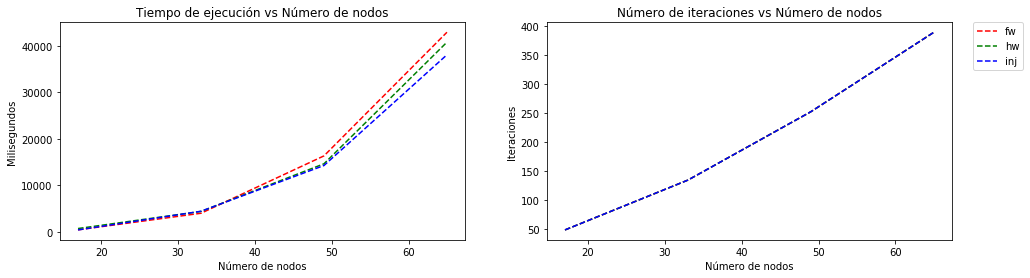

In [325]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4));

ax1.plot(smallnodes, [rt[n]["fw"]["time"] for n in smallnodes], 'r--', label="fw");
ax1.plot(smallnodes, [rt[n]["hw"]["time"] for n in smallnodes], 'g--', label="hw");
ax1.plot(smallnodes, [rt[n]["inj"]["time"] for n in smallnodes], 'b--', label="inj");
ax1.set_xlabel('Número de nodos')
ax1.set_ylabel('Milisegundos')
ax1.set_title('Tiempo de ejecución vs Número de nodos')

ax2.plot(smallnodes, [rt[n]["fw"]["loop"] for n in smallnodes], 'r--', label="fw");
ax2.plot(smallnodes, [rt[n]["hw"]["loop"] for n in smallnodes], 'g--', label="hw");
ax2.plot(smallnodes, [rt[n]["inj"]["loop"] for n in smallnodes], 'b--', label="inj");
ax2.set_xlabel('Número de nodos')
ax2.set_ylabel('Iteraciones')
ax2.set_title('Número de iteraciones vs Número de nodos')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show();

Los resultados parecen indicar que lo único que cambia es el tiempo de ejecución debido a la complejidad misma de la operación de restricción. Podemos notar como en todas las pruebas ejecutadas la resolución toma el mismo número de iteraciones, pero es ligeramente más lenta con las restricciones que utilizan más información. 

Este fenómeno parece indicar que es mejor utilizar simplemente injection, pues es el más rápido, pero estas pruebas no son concluyentes pues el número de nodos utilizados es muy pequeño.

## Conclusiones

Entre las concluciones de este trabajo tenemos:
1. A pesar que métodos como Gauss-Seidel puedan ser ejecutados directamente desde bibliotecas, los métodos generales o por definición son más lentos que métodos programados especificamente para la resolución de un problema puntual. Esto demuestra la utilidad de aprender correctamente el funcionamiento de los algoritmos y no solo limitarse a utilizar los ya implementados por otros.
2. La utilización de diversos algoritmos para la aproximación de soluciones iniciales y el refinamiento entre ciclos parece ser una de las formas principales de disminuir los tiempos de ejecución. En particular, algoritmos como *vcycle* y *multigrid* demuestran que no es necesario resolver el sistema de ecuaciones completo para llega a un resultado de buena calidad.
3. El movimiento de los problemas entre las mallas logra capturar correctamente las caracteristicas de baja y alta frecuencia de un problema y en base a ello mejora los resultados obtenidos notablemente.

Algunos problemas con los que nos topamos en el desarrollo de este informe son:
1. La capacidad de computo de la máquina en la que trabajamos nos dificultó efectual pruebas más grandes con los algoritmos. Si bien, en general, las tendencias lograron ser demostradas, algunos gráficos no muestran completamente fenomenos interesantes. Por ejemplo, el gráfico de tiempo de ejecución vs número de nodos para las implementaciones de Gauss-Seidel muestran indicios de que, con más de 113 nodos, la implementación sin matrices logrará mejorar el tiempo de el Gauss-Seidel con matrices *sparse*. 
2. Debido al mismo problema evidenciado en el punto 1, la comparación de los operadores de resticción no muestra mejoras para los operadores que utilizan más información. En un principio creíamos que *full weighting* obtendría mejores resultados que *injection* pero esta sospecha no se comprobó, pues en todas las pruebas gana *injection*. La experimentación con más nodos me dejaría con menos dudas.
3. Gran parte de las funciones implementadas en este proyecto podrían ser más eficientes en el consumo de memoría pues utilizan datos ya calculados. A pesar de que se intentó reutilizar lo más que se pudo (por medio del paso de parametros), algunos algoritmos hacian dificil este trabajo. En particular, se crea muchas veces la matriz A, y el vector b. Un sistema de caché para éstos podría mejorar considerablemente la carga final y disminuir los tiempos de ejecución.
4. El gran problema en este informe es que el algoritmo implemetado como *multigrid* deja de mejorar las soluciones despues de cierta cantidad de ciclos. Esto hace que todas las comparaciones que se puedan hacer no tengan mucho sentido ya que, a pesar de demorar menos en las pruebas, no se logra llegar a los mismos resultados. Este problema probablemente es causado por una mala interpretación del algoritmo o algún problema de programación que no fuimos capaces de encontrar.